In [40]:
import pandas as pd
import matplotlib.pyplot as plt

In [41]:
def get_config_label(config) -> str:
    return config[0] + ', ' + (
        'constr.' if config[1] else 'unconstr.'
    )

In [42]:
df = pd.read_csv('../results/perf.csv')

for r2_col in ['Train-R2', 'Test-R2', 'Extra-R2']:
    df.loc[df[r2_col] < 0.0, r2_col] = 0.0
    df[r2_col] = df[r2_col].fillna(0.0)


def plot_subgroup(i, config, group, axs):
    # feasibility ratio
        ax = axs[0][i]

        if i == 0: ax.set_ylabel('Fea. ratio')
        ax.set_xlabel(get_config_label(config))
        ax.xaxis.set_label_position('top')
        ax.xaxis.labelpad = 10
        ax.set_ylim(bottom=0.0, top=1.0)
        ax.tick_params(direction='in', length=5)
        
        x_features = ['Fea-Ratio', 'BestAvg-Fea-Ratio', 'BestWorst-Fea-Ratio']
        x_labels   = ['Best', 'Avg', 'Worst']
        group.boxplot(column=x_features, ax=ax)
        ax.set_xticklabels(x_labels, rotation=0)

        # data fitting.
        ax = axs[1][i]

        if i == 0: ax.set_ylabel('R2 score')
        ax.set_ylim(bottom=0.0, top=1.0)
        ax.tick_params(direction='in', length=5)
        
        x_features = ['Train-R2', 'Test-R2', 'Extra-R2', 'BestAvg-Train-R2']
        x_labels   = ['Train', 'Test', 'Extra', 'Avg']
        group.boxplot(column=x_features, ax=ax)
        ax.set_xticklabels(x_labels, rotation=0)


def plot_group(problem, problem_group):
    subgroups = problem_group.groupby(['Data-Config', 'Constrained'])
    
    fig, axs = plt.subplots(2, subgroups.ngroups, figsize=((15/6)*subgroups.ngroups, 4), sharey=True)
    fig.suptitle(problem, weight='bold', y=0.0)
    
    for i, (config, group) in enumerate(subgroups):
        plot_subgroup(i, config, group, axs)

In [43]:
df.head(5)

,Problem,Data-Config,Constrained,Train-R2,Test-R2,Fea-Ratio,Extra-R2,BestAvg-Train-R2,BestWorst-Train-R2,BestAvg-Fea-Ratio,BestWorst-Fea-Ratio,Size,Time,Model
0,feynman-i.6.20a,nonoise,True,0.984302,0.958704,1.000,0.974685,0.137191,0.0,0.679450,0.00,12,3.958494,(-0.51 / (log((0.19 - -0.08)) - (square(x0) * ...
1,feynman-i.6.20a,nonoise,False,0.922088,0.937419,0.995,0.938044,0.375829,0.0,0.808225,0.14,7,0.757309,exp((x0 - exp((x0 - 0.09))))
2,feynman-i.6.20a,noisy,True,0.888004,0.804602,1.000,0.982089,0.173624,0.0,0.777350,0.00,6,4.129359,sqrt((0.19 / exp(square(x0))))
3,feynman-i.6.20a,noisy,False,0.501852,0.501005,1.000,0.000000,0.067260,0.0,0.683850,0.00,7,0.659033,square(sqrt(sqrt(square((0.13 / x0)))))
4,feynman-i.29.4,nonoise,True,1.000000,1.000000,1.000,1.000000,0.766726,0.0,0.942836,0.00,21,3.722256,(x0 / ((0.03 * ((0.02 - x0) + (x0 - -0.07))) +...


### Confidence Interval

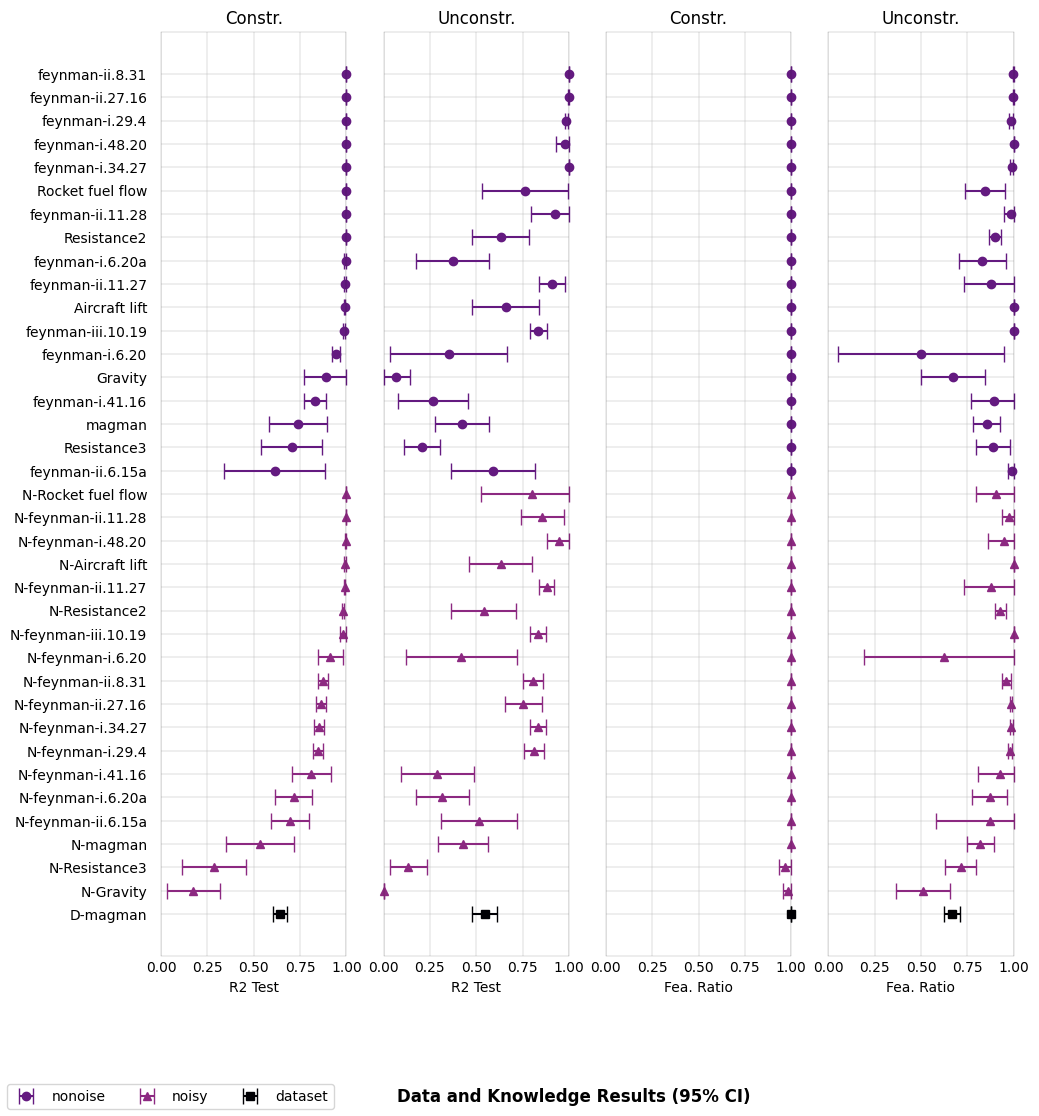

In [44]:
from scipy import stats
import numpy as np
import matplotlib

fig, axs = plt.subplots(1, 4, figsize=(11, 12), sharey=True)
nproblems = 0
problem_labels = []

cmap = matplotlib.colormaps.get_cmap('magma')
bar_colors = {'nonoise': cmap(0.3), 'noisy': cmap(0.4), 'dataset': cmap(0.0)}
problem_prefix = {'nonoise': '', 'noisy': 'N-', 'dataset': 'D-'}
fmt = {'nonoise': 'o', 'noisy': '^', 'dataset': 's'}
#fmt = {True: 'o', False: 'x'}
i = 0

for data_conf in ['nonoise', 'noisy', 'dataset']:

    problem_bars = []

    for problem, problem_group in df.loc[df['Data-Config'] == data_conf].groupby('Problem'):

        bars = {ax_idx: [] for ax_idx in range(4)}

        for isconstrained, constr_group in problem_group.groupby('Constrained'):
            
            for measure in ['Test-R2', 'Fea-Ratio']:
                offset = 0 if measure == 'Test-R2' else 2
                ax_idx = offset + (0 if isconstrained else 1)
                ax = axs[ax_idx]

                values = constr_group[measure].to_numpy()
                values[values < 0.0] = 0.0
                mean = values.mean()
                l, u = values.min(), values.max()
                if l != u:
                    l, u = stats.t.interval(0.95, values.size-1, loc=mean, scale=stats.sem(values))
                l = max(0.0, l)
                u = min(1.0, u)

                bars[ax_idx] = (mean, l, u, data_conf)
                #ax.errorbar(mean, i, xerr=[[mean-l],[u-mean]], fmt=fmt[data_conf], color=bar_colors[data_conf], elinewidth=1.5, capsize=6, label=data_conf)

        nproblems += 1
        problem_label = problem_prefix[data_conf] + problem
        problem_bars.append((problem_label, bars))

    problem_bars = sorted(problem_bars, reverse=True, key=lambda b: b[1][0][0])
    for problem_lbl, bars in problem_bars:
        problem_labels.append(problem_lbl)
        for ax_idx, (mean, l, u, data_conf) in bars.items():
            #constr = ax_idx == 1 or ax_idx == 3
            #if constr: ax_idx -= 1
            axs[ax_idx].errorbar(mean, i, xerr=[[mean-l],[u-mean]], fmt=fmt[data_conf], color=bar_colors[data_conf], elinewidth=1.5, capsize=6, label=data_conf, clip_on=False)
            #if not constr: i += 1
        i += 1

for ax in axs:
    ax.set_yticks(np.arange(nproblems))
    ax.tick_params(direction='in', length=0)
    ax.grid(linewidth=0.3)
    for side in ['top','bottom','left','right']:
        ax.spines[side].set_linewidth(0.1)

axs[0].set_xlim([0.0, 1.0])
axs[0].set_yticklabels(problem_labels)
axs[0].tick_params(axis='y', pad=10)
axs[0].set_title("Constr.")
axs[0].set_xlabel("R2 Test")

axs[1].set_xlim([0.0, 1.0])
axs[1].set_title("Unconstr.")
axs[1].set_xlabel("R2 Test")

axs[2].set_xlim([0.0, 1.0])
axs[2].set_title("Constr.")
axs[2].set_xlabel("Fea. Ratio")

axs[3].set_xlim([0.0, 1.0])
axs[3].set_title("Unconstr.")
axs[3].set_xlabel("Fea. Ratio")

fig.suptitle('Data and Knowledge Results (95% CI)', weight='bold', y=0.0)
plt.gca().invert_yaxis()

def legend_without_duplicate_labels(figure):
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    figure.legend(by_label.values(), by_label.keys(), loc='lower left', ncol=3)

legend_without_duplicate_labels(fig)

plt.savefig('../figs/meeting/results.pdf', bbox_inches='tight')
plt.show()

### Statistic Test

In [ ]:
from scipy.stats import ttest_ind

problem_name_prefix = {'nonoise': '', 'noisy': 'N-', 'dataset': 'D-'}
header = ['Problem', 'p-value (constr. > unconstr.)', 'p-value (constr. ≠ unconstr.)']
table = []

for data_conf in ['nonoise', 'noisy', 'dataset']:
    for problem, problem_group in df.loc[df['Data-Config'] == data_conf].groupby('Problem'):

        constr_group = None
        unconstr_group = None
        
        for isconstrained, constr_group in problem_group.groupby('Constrained'):
            values = constr_group['Extra-R2'].to_numpy()
            if isconstrained: constr_group = values
            else: unconstr_group = values
        
        stat_gr, pval_gr = ttest_ind(constr_group, unconstr_group, equal_var=False, alternative='greater')
        stat_neq, pval_neq = ttest_ind(constr_group, unconstr_group, equal_var=False, alternative='two-sided')
        problem_name = problem_name_prefix[data_conf] + problem

        table.append([problem_name, pval_gr, pval_neq])

pd.DataFrame(table, columns=header)

### Box Plots

In [ ]:
plot_group('All', df)
for problem, problem_group in df.groupby('Problem'):
    plot_group(problem, problem_group)